### Measuring Entity Susceptibility Scores in Movie Reviews with Conditional MI

In [1]:
import yaml
from itertools import product
import pandas as pd
import seaborn as sns
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
import numpy as np
import math
import statsmodels.api as sm
from measuring.estimate_probs import (
    estimate_prob_y_given_context_and_entity, 
    estimate_prob_x_given_e, 
    estimate_prob_next_word_given_x_and_entity, 
    estimate_cmi, score_model_for_next_word_prob, 
    create_position_ids_from_input_ids, 
    sharded_score_model,
    estimate_entity_score,
    kl_div,
    difference,
    difference_p_good_only,
    difference_abs_val,
)


/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COMPUTE_CMI = False
COMPUTE_KL = False
COMPUTE_GOOD_BAD = False
COMPUTE_GOOD_BAD_ABS = True
COMPUTE_GOOD_BAD_P_GOOD_ONLY = True

In [3]:
with open('toy_movie_reviews.yaml', 'r') as file:
    review_adjs = yaml.safe_load(file)

In [4]:
pos_adjs_train = review_adjs["positive_adjectives_train"]
neg_adjs_train = review_adjs["negative_adjectives_train"]

pos_verbs = review_adjs["positive_verbs"]
neg_verbs = review_adjs["negative_verbs"]

In [5]:
movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv
movies = movies[["title", "vote_count", "popularity"]].dropna().sort_values(by="vote_count")
movies["popularity"] = movies["popularity"].astype(float)
# movies_sample = pd.concat([movies.iloc[:250], movies.iloc[-250:]], axis=0)
movies_sample = pd.concat([movies.iloc[-250:]], axis=0)
movies_sample

/tmp/ipykernel_16474/3729679061.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv") # https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv


,title,vote_count,popularity
12648,Kung Fu Panda,3231.0,16.897541
23360,Godzilla,3232.0,14.019239
23472,Mission: Impossible - Rogue Nation,3274.0,17.836882
1158,Aliens,3282.0,21.761179
20335,Hansel & Gretel: Witch Hunters,3290.0,10.337211
...,...,...,...
26564,Deadpool,11444.0,187.860492
17818,The Avengers,12000.0,89.887648
14551,Avatar,12114.0,185.070892
12481,The Dark Knight,12269.0,123.167259


In [6]:
movies_sample

,title,vote_count,popularity
12648,Kung Fu Panda,3231.0,16.897541
23360,Godzilla,3232.0,14.019239
23472,Mission: Impossible - Rogue Nation,3274.0,17.836882
1158,Aliens,3282.0,21.761179
20335,Hansel & Gretel: Witch Hunters,3290.0,10.337211
...,...,...,...
26564,Deadpool,11444.0,187.860492
17818,The Avengers,12000.0,89.887648
14551,Avatar,12114.0,185.070892
12481,The Dark Knight,12269.0,123.167259


<Axes: xlabel='vote_count', ylabel='popularity'>

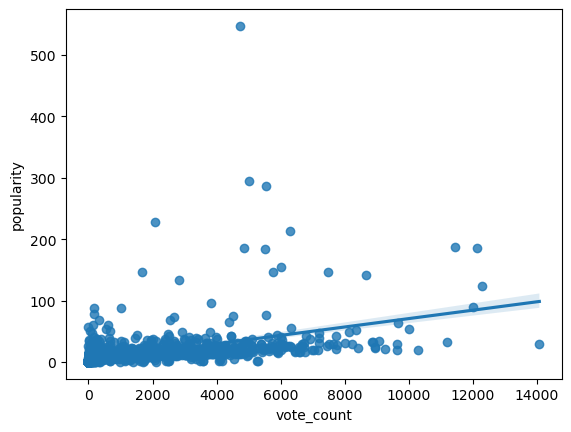

In [7]:
# WHETHER TO USE VOTE COUNT OR POPULARITY

# movies.sort_values(by="popularity").tail(50)
# movies.sort_values(by="vote_count").tail(50)
sns.regplot(data=movies, x="vote_count", y="popularity")

In [8]:
template = "Here's a review for the movie '{}': I thought this movie was {}, I {} it.\nConclusion: This movie is"
template.format(movies_sample["title"].iloc[0], pos_adjs_train[0], pos_verbs[0])
movies_sample["sentence"] = movies_sample["title"].apply(lambda title: template.format(title, pos_adjs_train[0], pos_verbs[0])) 


In [9]:
context_template = "Here's a movie review: 'The movie was {} and I {} it'. "
num_adjs = min(len(pos_adjs_train), len(neg_adjs_train))
num_verbs = min(len(pos_verbs), len(neg_verbs))

pos_contexts = [context_template.format(adj, verb) for (adj, verb) in product(pos_adjs_train[:num_adjs], pos_verbs[:num_verbs])]
neg_contexts = [context_template.format(adj, verb) for (adj, verb) in product(neg_adjs_train[:num_adjs], neg_verbs[:num_verbs])]
contexts = neg_contexts
# contexts = pos_contexts + neg_contexts

print("Number of positive contexts: ", len(pos_contexts))
print("Number of negative contexts: ", len(neg_contexts))
print(contexts[::10])

Number of positive contexts:  72
Number of negative contexts:  72
["Here's a movie review: 'The movie was dreadful and I hated it'. ", "Here's a movie review: 'The movie was depressing and I disliked it'. ", "Here's a movie review: 'The movie was nasty and I despised it'. ", "Here's a movie review: 'The movie was ugly and I hated it'. ", "Here's a movie review: 'The movie was annoying and I disliked it'. ", "Here's a movie review: 'The movie was frustrating and I despised it'. ", "Here's a movie review: 'The movie was unpleasant and I hated it'. ", "Here's a movie review: 'The movie was awful and I disliked it'. "]


In [10]:
def format_query(query, entity, context, prefix=""):
    return prefix + context + query.format(entity)

In [11]:
# from functools import partial
# def fill_in_template(template: str, title: str, adj: str, verb: str):
#     return template.format(title, adj, verb)

# pos_template_partial = partial(fill_in_template, template=template, verb=pos_verbs[0])
# neg_template_partial = partial(fill_in_template, template=template, verb=neg_verbs[0])

# for adj in pos_adjs_train:
#     movies_sample[f"pos_{adj}_context"] = movies_sample["title"].apply(lambda title: pos_template_partial(title=title, adj=adj))

# for adj in neg_adjs_train:
#     movies_sample[f"neg_{adj}_context"] = movies_sample["title"].apply(lambda title: neg_template_partial(title=title, adj=adj))

In [12]:
movies_sample.head()

,title,vote_count,popularity,sentence
12648,Kung Fu Panda,3231.0,16.897541,Here's a review for the movie 'Kung Fu Panda':...
23360,Godzilla,3232.0,14.019239,Here's a review for the movie 'Godzilla': I th...
23472,Mission: Impossible - Rogue Nation,3274.0,17.836882,Here's a review for the movie 'Mission: Imposs...
1158,Aliens,3282.0,21.761179,Here's a review for the movie 'Aliens': I thou...
20335,Hansel & Gretel: Witch Hunters,3290.0,10.337211,Here's a review for the movie 'Hansel & Gretel...


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "EleutherAI/pythia-70m-deduped"


model = GPTNeoXForCausalLM.from_pretrained(
  model_name,
  # load_in_8bit=True,
  # revision="step3000",
  # cache_dir="./pythia-70m-deduped/step3000",
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
  model_name,
  padding_side="left",
  # revision="step3000",
  # cache_dir="./pythia-70m-deduped/step3000",
)

query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
inputs = tokenizer(format_query(query=query, entity=movies_sample.iloc[0]["title"], context=contexts[0]), return_tensors="pt").to(device)
# inputs = tokenizer(movies_sample.iloc[0]["sentence"], return_tensors="pt").to(device)
tokens = model.generate(**inputs)
probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)
print(sum(probs))
tokenizer.decode(top_tokens)
# print(tokens)
# tokenizer.decode(tokens[0])


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/kevin/mambaforge/envs/measurelm2/lib/python3.10/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 41, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/tmp/ipykernel_16474/362821314.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs, top_tokens = torch.topk(torch.nn.functional.softmax(model(**inputs).logits[0, -1]), k=10)


tensor(0.6786, device='cuda:0', grad_fn=<AddBackward0>)


'\n�iced�001icky002........ire�'

In [14]:
answer_map = {
    0: ["0", "zero", "Zero"],
    1: ["1", "one", "One"],
    2: ["2", "two", "Two"],
    3: ["3", "three", "Three"],
    4: ["4", "four", "Four"],
    5: ["5", "five", "Five"],
}
answer_map_token_ids = {k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device) for k, v in answer_map.items()}
answer_map_token_ids

{0: tensor([   17, 10528, 26561], device='cuda:0'),
 1: tensor([  18,  531, 4041], device='cuda:0'),
 2: tensor([  19, 9389, 7910], device='cuda:0'),
 3: tensor([   20, 13524, 11831], device='cuda:0'),
 4: tensor([   21, 12496, 14039], device='cuda:0'),
 5: tensor([   22, 12071, 25438], device='cuda:0')}

In [15]:
if COMPUTE_CMI:
    query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=None))
    # movies_sample["susceptibility_score"] = movies_sample["title"].progress_apply(lambda e: estimate_cmi(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, answer_map=answer_map_token_ids))

In [16]:
if COMPUTE_CMI:
    movies_sample.value_counts("susceptibility_score")
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score"]
    ols_model = sm.OLS(y, x).fit()
    ols_model.summary()

In [17]:
if COMPUTE_KL:
    query = "On a scale from 1 to 5 stars, the quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    # movies_sample["susceptibility_score_kl"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=kl_div, answer_map=None))
    movies_sample["susceptibility_score_kl"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=kl_div, answer_map=answer_map_token_ids))


In [18]:
if COMPUTE_KL:
    print(movies_sample.value_counts("susceptibility_score_kl"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_kl")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_kl"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

In [19]:
answer_map_good_bad = {
    0: ["bad", "Bad"],
    1: ["good", "Good"],
}
answer_map_good_bad_token_ids = {
    k: torch.tensor(tokenizer.convert_tokens_to_ids(v), device=model.device) for k, v in answer_map_good_bad.items()
}

if COMPUTE_GOOD_BAD:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=difference, answer_map=answer_map_good_bad_token_ids))


In [20]:
if COMPUTE_GOOD_BAD:
    print(movies_sample.value_counts("susceptibility_score_good_bad"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_good_bad")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

  1%|          | 2/250 [00:00<00:13, 18.83it/s]

Setting model.config.pad_token_id to model.config.eos_token_id


100%|██████████| 250/250 [00:24<00:00, 10.26it/s]


susceptibility_score_good_bad_abs
1.421395    1
0.450780    1
1.145370    1
1.159229    1
1.162780    1
           ..
0.576304    1
0.578580    1
0.606373    1
0.606419    1
0.617125    1
Name: count, Length: 250, dtype: int64
                                    OLS Regression Results                                   
Dep. Variable:     susceptibility_score_good_bad_abs   R-squared:                       0.016
Model:                                           OLS   Adj. R-squared:                  0.012
Method:                                Least Squares   F-statistic:                     4.143
Date:                               Mon, 04 Dec 2023   Prob (F-statistic):             0.0429
Time:                                       23:48:51   Log-Likelihood:                 105.74
No. Observations:                                250   AIC:                            -207.5
Df Residuals:                                    248   BIC:                            -200.4
Df Model:            

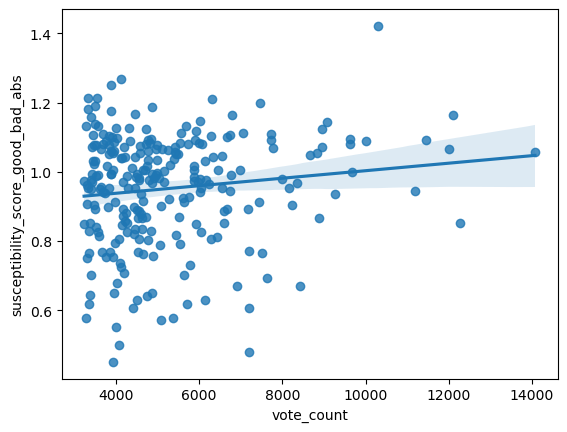

In [21]:
if COMPUTE_GOOD_BAD_ABS:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad_abs"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=difference_abs_val, answer_map=answer_map_good_bad_token_ids))

if COMPUTE_GOOD_BAD_ABS:
    print(movies_sample.value_counts("susceptibility_score_good_bad_abs"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_good_bad_abs")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad_abs"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())

100%|██████████| 250/250 [00:27<00:00,  9.16it/s]


susceptibility_score_good_bad_p_good_only
-0.225390    1
-0.710698    1
-0.324676    1
-0.322508    1
-0.320650    1
            ..
-0.604999    1
-0.599864    1
-0.594659    1
-0.593515    1
-0.591028    1
Name: count, Length: 250, dtype: int64
                                        OLS Regression Results                                       
Dep. Variable:     susceptibility_score_good_bad_p_good_only   R-squared:                       0.016
Model:                                                   OLS   Adj. R-squared:                  0.012
Method:                                        Least Squares   F-statistic:                     4.143
Date:                                       Mon, 04 Dec 2023   Prob (F-statistic):             0.0429
Time:                                               23:49:19   Log-Likelihood:                 279.03
No. Observations:                                        250   AIC:                            -554.1
Df Residuals:                           

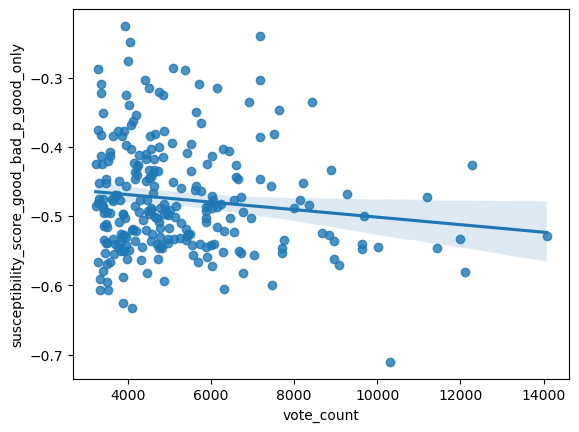

In [22]:
if COMPUTE_GOOD_BAD_P_GOOD_ONLY:
    query = "The quality of this movie, '{}', is rated "
    from tqdm import tqdm
    tqdm.pandas()
    movies_sample["susceptibility_score_good_bad_p_good_only"] = movies_sample["title"].progress_apply(lambda e: estimate_entity_score(query=query, entity=e, contexts=contexts, model=model, tokenizer=tokenizer, distance_metric=difference_p_good_only, answer_map=answer_map_good_bad_token_ids))

if COMPUTE_GOOD_BAD_P_GOOD_ONLY:
    print(movies_sample.value_counts("susceptibility_score_good_bad_p_good_only"))
    sns.regplot(data=movies_sample, x="vote_count", y="susceptibility_score_good_bad_p_good_only")
    x = movies_sample["vote_count"]
    x = sm.add_constant(x)
    y = movies_sample["susceptibility_score_good_bad_p_good_only"]
    ols_model = sm.OLS(y, x).fit()
    print(ols_model.summary())